# Лабораторная работа №4

## Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

Цель лабораторной работы: изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

Задание:
    
1. Выберите набор данных (датасет) для решения задачи классификации или регресии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.
5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.
6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.
7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.
8. Постройте кривые обучения и валидации.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import median_absolute_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, RepeatedKFold, ShuffleSplit
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
# Enable inline plots
%matplotlib inline

## Выбор набора данных(датасета) и исследование его

In [2]:
data = pd.read_csv('camera_dataset.csv', sep=',')
data.head(10)

,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0
5,Agfa ePhoto CL45,2001,1600.0,640.0,1.0,51.0,51.0,50.0,20.0,8.0,270.0,119.0,179.0
6,Agfa ePhoto CL50,1999,1280.0,640.0,1.0,34.0,102.0,0.0,0.0,8.0,0.0,0.0,179.0
7,Canon PowerShot 350,1997,640.0,0.0,0.0,42.0,42.0,70.0,3.0,2.0,320.0,93.0,149.0
8,Canon PowerShot 600,1996,832.0,640.0,0.0,50.0,50.0,40.0,10.0,1.0,460.0,160.0,139.0
9,Canon PowerShot A10,2001,1280.0,1024.0,1.0,35.0,105.0,76.0,16.0,8.0,375.0,110.0,139.0


In [3]:
data.shape 

(1038, 13)

In [4]:
data.dtypes 

Model                       object
Release date                 int64
Max resolution             float64
Low resolution             float64
Effective pixels           float64
Zoom wide (W)              float64
Zoom tele (T)              float64
Normal focus range         float64
Macro focus range          float64
Storage included           float64
Weight (inc. batteries)    float64
Dimensions                 float64
Price                      float64
dtype: object

In [5]:
data.isnull().sum() 

Model                      0
Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          1
Storage included           2
Weight (inc. batteries)    2
Dimensions                 2
Price                      0
dtype: int64

## Удаление или заполнение пропусков и кодирование категориальных признаков

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
# кодирование категориальных признаков числовыми
le = LabelEncoder()
data['Model'] = le.fit_transform(data['Model'])

In [8]:
# заполнение 0 пропусков
data = data.fillna(0)

In [9]:
data.dtypes

Model                        int32
Release date                 int64
Max resolution             float64
Low resolution             float64
Effective pixels           float64
Zoom wide (W)              float64
Zoom tele (T)              float64
Normal focus range         float64
Macro focus range          float64
Storage included           float64
Weight (inc. batteries)    float64
Dimensions                 float64
Price                      float64
dtype: object

In [10]:
data.isnull().sum() 

Model                      0
Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          0
Storage included           0
Weight (inc. batteries)    0
Dimensions                 0
Price                      0
dtype: int64

In [11]:
data.head()

,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,0,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,1,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,2,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,3,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,4,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


## 3. С использованием метода train_test_split разделение выборки на обучающую и тестовую.

Разделим данные на целевой столбец и признаки.

In [12]:
 # Перейдем к разделению выборки на обучающую и тестовую.
X = data.drop('Price',axis = 1).values 
y = data['Price'].values 

Разделим выборку на тренировочную и тестовую.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25, random_state=1)

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(778, 12)
(778,)
(260, 12)
(260,)


## 4.Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью трех подходящих для задачи метрик.

In [15]:
def test_model(model):
    print("mean_absolute_error:", mean_absolute_error(y_test, model.predict(X_test)))
    print("median_absolute_error:", median_absolute_error(y_test, model.predict(X_test)))
    print("r2_score:", r2_score(y_test, model.predict(X_test)))

In [16]:
reg_5 = KNeighborsRegressor(n_neighbors=5)
reg_5.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [17]:
# Проверим метрики построенной модели
test_model(reg_5)

mean_absolute_error: 261.42538461538464
median_absolute_error: 88.6
r2_score: 0.4890065578434296


## 5. Постройте модель и оцените качество модели с использованием кросс-валидации. Проведите эксперименты с тремя различными стратегиями кросс-валидации.

## K-Fold

In [18]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y, cv=KFold(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[ 3.96144079e-01  3.08502042e-01  6.05100579e-01 -2.26865221e+02
 -7.12193756e-01 -1.97581844e-02 -2.21147578e-01 -8.96818039e-01
 -2.32375502e-01 -5.93909805e-01]
-22.82316772695667 ± 68.01561914203118


## Repeated K-Fold

In [19]:
 scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y, cv=RepeatedKFold(n_splits=5, n_repeats=2),
scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())


[0.29347721 0.54424372 0.47240878 0.34320308 0.37280208 0.28876594
 0.45384161 0.1702454  0.42135621 0.48719655]
0.38475405601243023 ± 0.10731079044848114


## Shuffle Split

In [20]:
scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X, y, cv=ShuffleSplit(n_splits=10), scoring="r2")
print(scores)
print(scores.mean(), "±", scores.std())

[0.51515142 0.38724837 0.36280853 0.44604506 0.45866545 0.19705988
 0.26139833 0.24453421 0.57619614 0.44395803]
0.3893065410088872 ± 0.1169470208872942


## 6. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.

In [21]:
n_range = np.array(range(1, 14, 2))
tuned_parameters = [{'n_neighbors': n_range}]
n_range

array([ 1,  3,  5,  7,  9, 11, 13])

In [22]:
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters,
cv=ShuffleSplit(n_splits=10), scoring="r2",
return_train_score=True, n_jobs=-1)
gs.fit(X, y)
gs.best_params_

{'n_neighbors': 5}

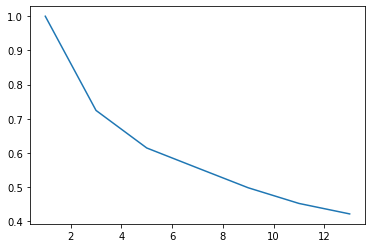

In [23]:
plt.plot(n_range, gs.cv_results_["mean_train_score"])

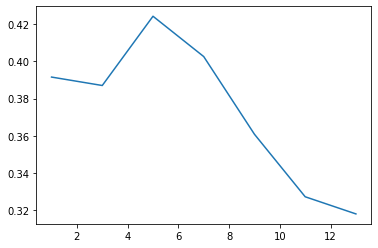

In [24]:
plt.plot(n_range, gs.cv_results_["mean_test_score"])

## 7. Повторите пункт 4 для найденного оптимального значения гиперпараметра K. Сравните качество полученной модели с качеством модели, полученной в пункте 4.

In [25]:
reg = KNeighborsRegressor(**gs.best_params_)
reg.fit(X_train, y_train)
test_model(reg)

mean_absolute_error: 261.42538461538464
median_absolute_error: 88.6
r2_score: 0.4890065578434296


## 8. Постройте кривые обучения и валидации.

In [26]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None):
    train_sizes=np.linspace(.1, 1.0, 5)
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
    estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from 'c:\\users\\innap\\miniconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

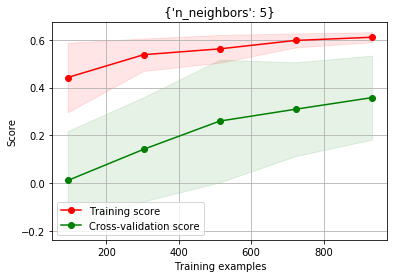

In [27]:
plot_learning_curve(reg, str(gs.best_params_), X, y,
cv=ShuffleSplit(n_splits=10))

In [28]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
    estimator, X, y, param_name=param_name,
    param_range=param_range,
    cv=cv, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
    color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std, alpha=0.2,
    color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean,
    label="Cross-validation score",
    color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std, alpha=0.2,
    color="navy", lw=lw)
    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from 'c:\\users\\innap\\miniconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

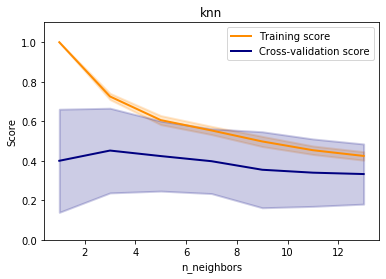

In [29]:
plot_validation_curve(KNeighborsRegressor(), "knn", X, y,
param_name="n_neighbors", param_range=n_range,
cv=ShuffleSplit(n_splits=10), scoring="r2")

Вывод: при выполнении лабораторной работы были исследованы данные о видео-камерах, данные были очищены от пропусков, также производилось преобразование категориальных признаков в числовые. Были подобраны гиперпараметры при помощи метода ближайших соседей, при помощи найденного гиперпараметра К впоследствии была обучена модель.